In [1]:
import os
import re
import pdfplumber
import numpy as np
import pandas as pd 
import json
import tabula

import plotly.graph_objs as go
import datetime as dt
import plotly as py
from plotly.subplots import make_subplots

os.chdir(r'C:\Users\Owner\OneDrive\Research_Git\DS_Misc\Credit_DealDoc_Proc')
import scrape

In [2]:
# Enable multiple output per cell. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
data = tabula.read_pdf('OHA XII Indenture.pdf', 
                       multiple_tables=True, pages=list(np.arange(13,20)))

### Table Processing: Aggregate Risk Pricing 
Different table types: Use Tabula
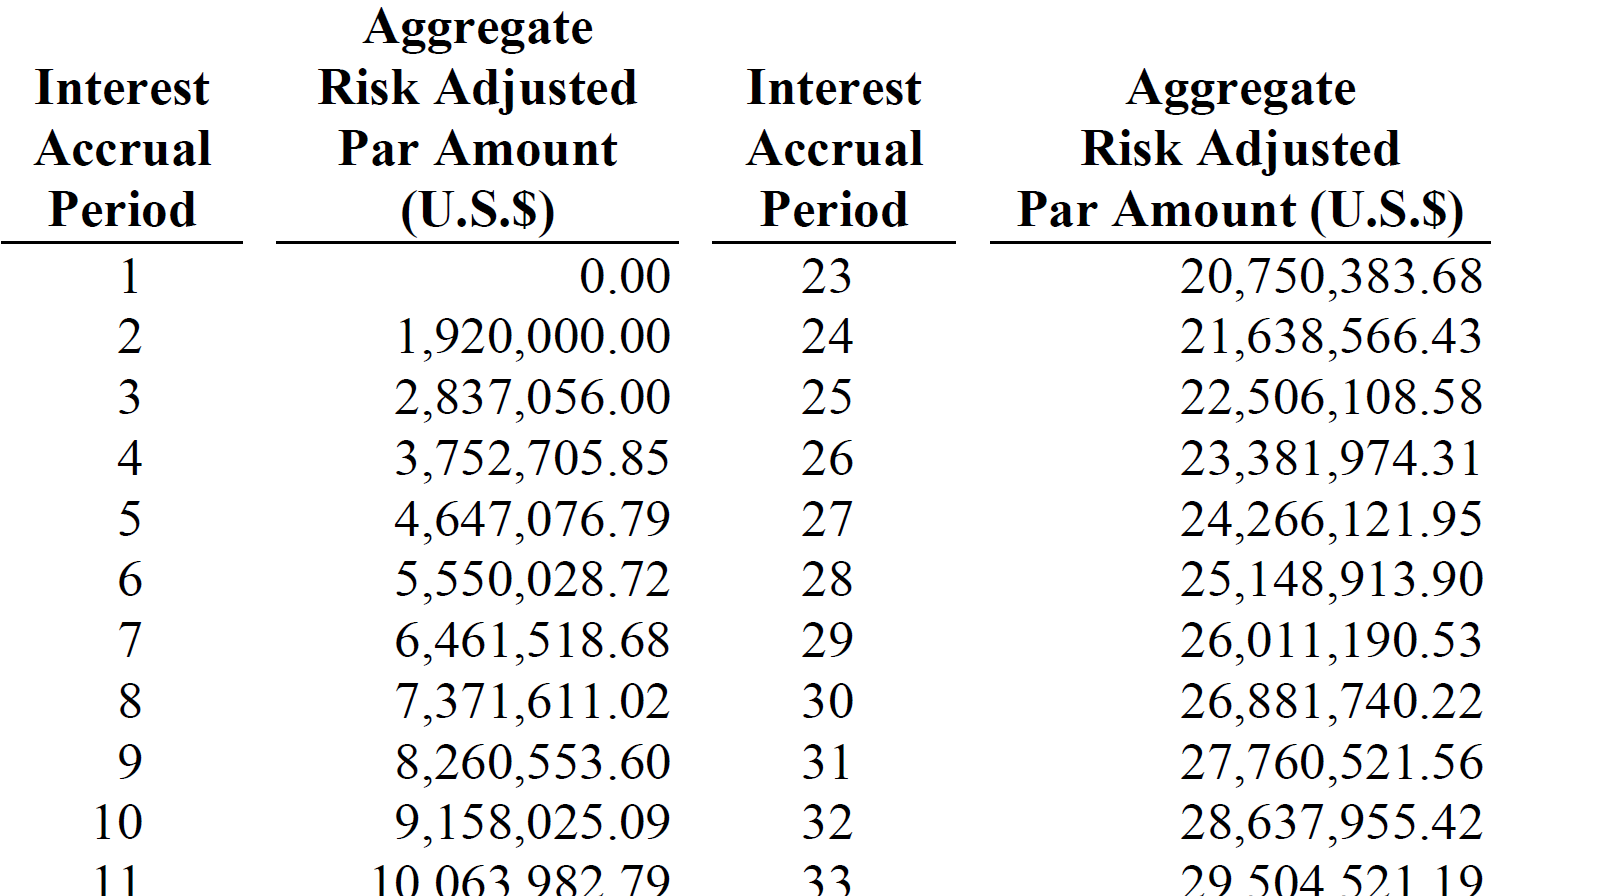
Also note there are really two fields: 
1. Accrual Period for Interest
2. Aggregate Risk-Adjusted Par Amounnt <br> 

Columns 3 & 4 are a continuation of columns 1 & 2. 

In [4]:
# Look at first page of data: Aggregate Risk
data[0].head() 
data[0].shape

,1,0.00,23,"20,750,383.68"
0,2,"1,920,000.00",24,"21,638,566.43"
1,3,"2,837,056.00",25,"22,506,108.58"
2,4,"3,752,705.85",26,"23,381,974.31"
3,5,"4,647,076.79",27,"24,266,121.95"
4,6,"5,550,028.72",28,"25,148,913.90"


(21, 4)

Can see **Aggregate Risk Adjusted Par Amount** values coming okay, but the first row is treated as a title. 
1. Shift column names down to first row and rename.
2. Separate 1st/2nd and 3rd/4th columns and concatenate into one dataframe. 

In [5]:
col_names = ['Period1','Par1','Period2','Par2']
aggrisk = scrape.shift_colnames_1strow(data[0], col_names)  # shifts columns down into first row 
aggrisk1 = aggrisk[['Period1', 'Par1']]
aggrisk2 = aggrisk[['Period2','Par2']]
aggrisk1.columns = aggrisk2.columns = ['Int_Accrual_Period','ARAP']
aggrisk = pd.concat([aggrisk1, aggrisk2],axis=0).reset_index(drop=True) 
aggrisk.head() 
aggrisk.shape

,Int_Accrual_Period,ARAP
0,1,0.00
1,2,"1,920,000.00"
2,3,"2,837,056.00"
3,4,"3,752,705.85"
4,5,"4,647,076.79"


(44, 2)

### Table Processing (*lists within table*): Asset Quality Matrix
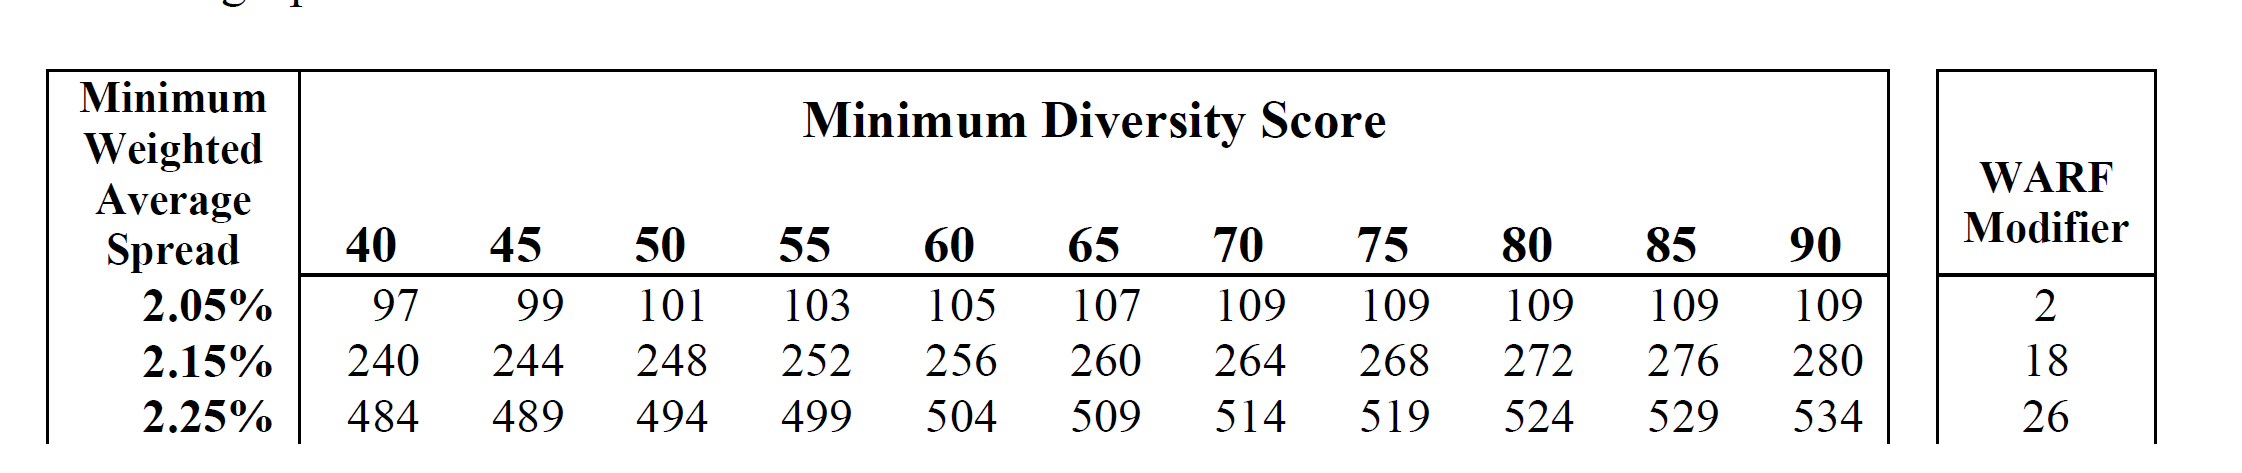
Issues to work through: 
1. Headers shifted down: This the opposite problem to ARAP since column titles were shifted into rows (instead of first row shifted into title). We create a new df removing these rows and add back in the column names 
2. There are lists of different lengths (5 elements on page, 6 elements page 2) for each page. We split out these lists into separate dfs, then concat them back to the originaol
3. Table spans two pages: concat individual pages together. 

In [6]:
# Sample of column headings showing up data
data[1].head() 

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Minimum,NaN,NaN,NaN,Minimum Diversity Score,NaN,NaN,NaN,NaN
1,Weighted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WARF
3,Spread,40.0,45.0,50.0,55 60 65 70 75,80.0,85.0,90.0,Modifier
4,2.05%,97.0,99.0,101.0,103 105 107 109 109,109.0,109.0,109.0,2


In [9]:
# set column names for boh pages then add them into table. 
mindiv1_cols = ['MWAS','40','45','50','MDS','80', '85', '90','WARF_Modifier']
mindiv2_cols = ['MWAS','40','45','50','MDS','85','Skip','90','WARF_Modifier']
df_mindiv1 = scrape.remrows_table_rename(data[1], mindiv1_cols, 4)
df_mindiv2 = scrape.remrows_table_rename(data[2][:-1], mindiv2_cols, 4)  # remove last record 
df_mindiv1.head() 

,MWAS,40,45,50,MDS,80,85,90,WARF_Modifier
0,2.05%,97.0,99.0,101.0,103 105 107 109 109,109.0,109.0,109.0,2
1,2.15%,240.0,244.0,248.0,252 256 260 264 268,272.0,276.0,280.0,18
2,2.25%,484.0,489.0,494.0,499 504 509 514 519,524.0,529.0,534.0,26


Split out Strings with columns

In [11]:
MDS1_cols = ['55','60','65','70','75']
MDS2_cols = ['55','60','65','70','75','80'] 
df_mindiv1 = scrape.split_lists_newdf(df_mindiv1, 'MDS', MDS1_cols, ' ')
df_mindiv2 = scrape.split_lists_newdf(df_mindiv2, 'MDS', MDS2_cols, ' ')
df_mindiv2[0:2]

,MWAS,40,45,50,MDS,85,Skip,90,WARF_Modifier,55,60,65,70,75,80
0,2.35%,675.0,681,687.0,693 699 705 711 717 723,729.0,NaN,735.0,31,693,699,705,711,717,723
1,2.45%,895.0,903,911.0,919 927 935 943 951 959,967.0,NaN,975.0,37,919,927,935,943,951,959


In [12]:
# Reorder concatenated pages 
mindiv_cols = ['MWAS','40','45','50','55','60','65','70','75','80','85','90','WARF_Modifier']
df_mindiv1 =df_mindiv1[mindiv_cols]
df_mindiv2 =df_mindiv2[mindiv_cols]

In [13]:
# combine pages and reset_index
df_mindiv = pd.concat([df_mindiv1,df_mindiv2],axis=0).reset_index(drop=True)  # 'drop=True' prevents new columns from being formed 
df_mindiv.shape
df_mindiv.head() 

(37, 13)

,MWAS,40,45,50,55,60,65,70,75,80,85,90,WARF_Modifier
0,2.05%,97.0,99,101.0,103,105,107,109,109,109,109.0,109.0,2
1,2.15%,240.0,244,248.0,252,256,260,264,268,272,276.0,280.0,18
2,2.25%,484.0,489,494.0,499,504,509,514,519,524,529.0,534.0,26
3,2.35%,675.0,681,687.0,693,699,705,711,717,723,729.0,735.0,31
4,2.45%,895.0,903,911.0,919,927,935,943,951,959,967.0,975.0,37
